In [1]:
dnn_attack_intensity = 9

In [2]:
from models.ae import AE
from models.dnnAE import DNN

import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat

In [3]:
seed = 13
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

# **DNN Data Generation**

In [5]:
Z = defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']

Z = dict(sorted(Z.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


In [6]:
latent_dim = 118
no_residuals = 1

## **Load Trained Models**

In [7]:
noise_levels = [0, 5, 10, 20, 50]
aes = dict()
for level in noise_levels:
    ae = AE(latent_dim).to(device)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

dnn = DNN(no_residuals=no_residuals).to(device)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **Normal Sensor Data To DNN Data**

In [8]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnn(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 10.00it/s]


## **Attack Sensor Data To DNN Data**

In [9]:
pred = defaultdict()
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred[level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]


In [10]:
y = []
no_signal = len(Z[0])
for l in range(4):
    y.append(F.one_hot(l * torch.ones((no_signal), dtype=torch.long), num_classes=4))
y = torch.cat(y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       0.98      1.00      0.99      3288
           3       1.00      0.98      0.99      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


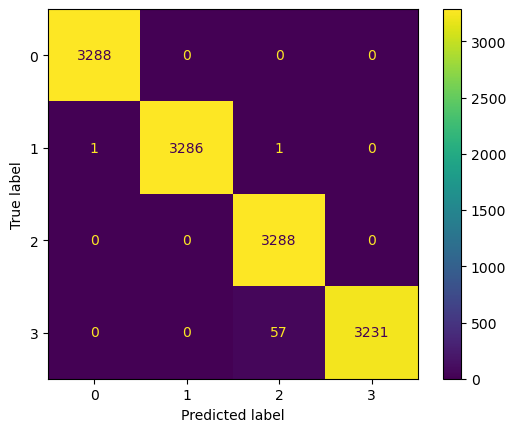

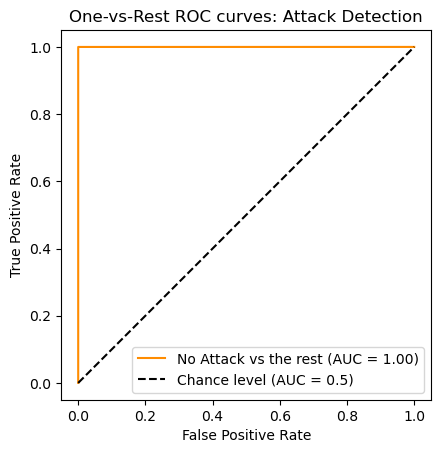

In [11]:
severity = 5
level = 0
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      1.00      1.00      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


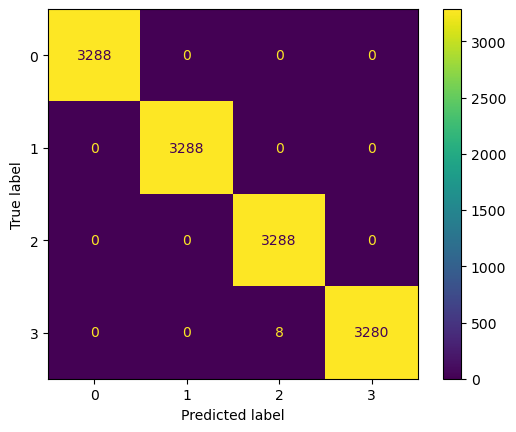

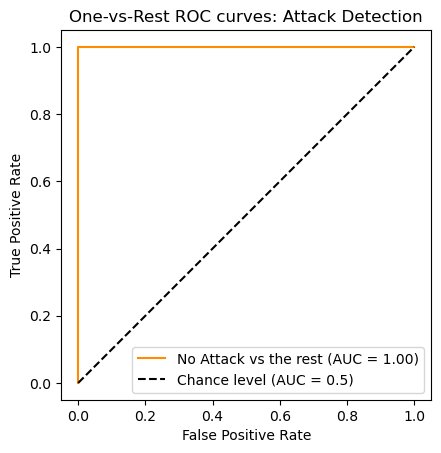

In [12]:
severity = 6
level = 0
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      1.00      1.00      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


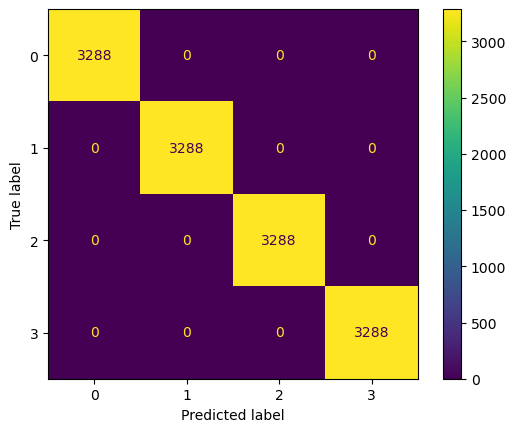

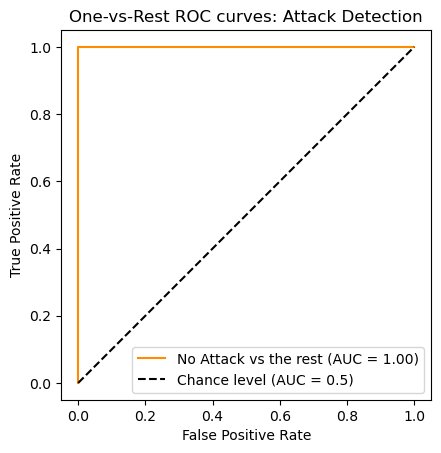

In [13]:
severity = 7
level = 0
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      1.00      1.00      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


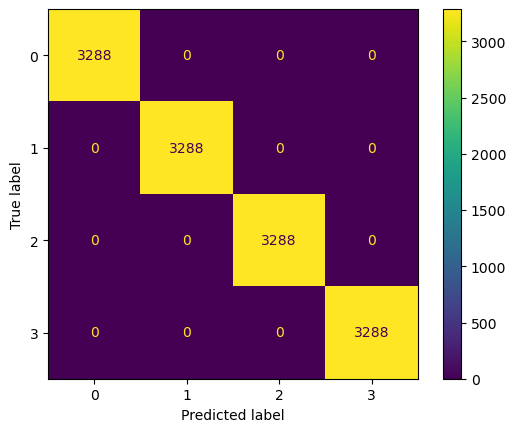

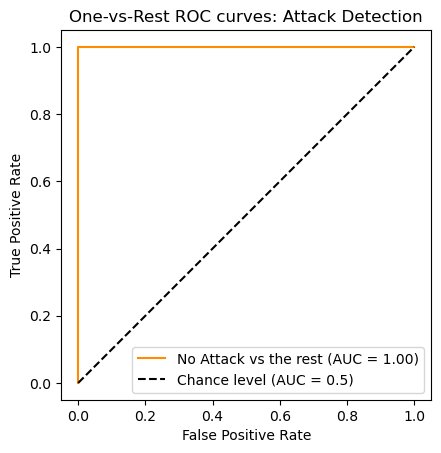

In [14]:
severity = 8
level = 0
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      1.00      1.00      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


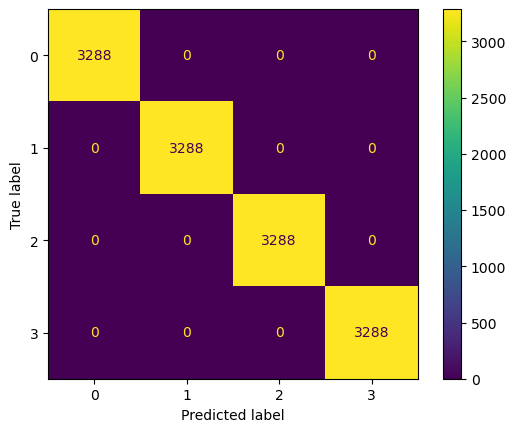

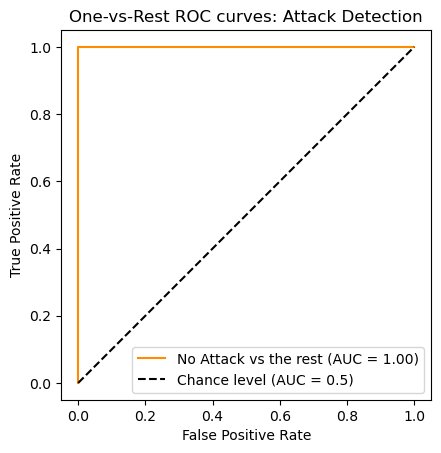

In [15]:
severity = 9
level = 0
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 5%**

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3288
           1       1.00      1.00      1.00      3288
           2       0.89      1.00      0.94      3288
           3       0.89      0.88      0.89      3288

    accuracy                           0.94     13152
   macro avg       0.95      0.94      0.94     13152
weighted avg       0.95      0.94      0.94     13152

Confusion Matrix:


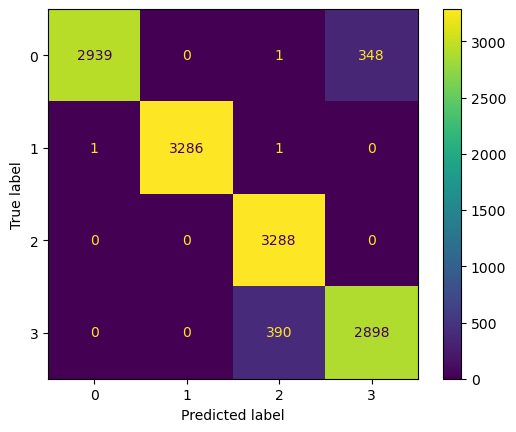

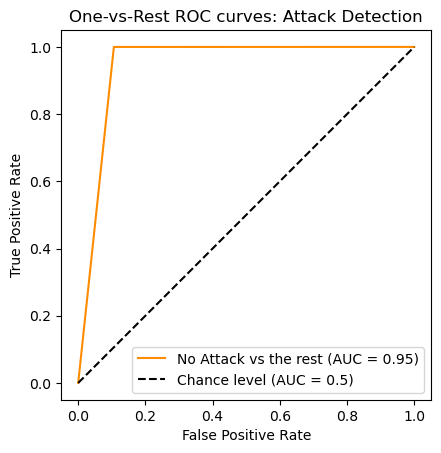

In [16]:
severity = 5
level = 5
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3288
           1       1.00      1.00      1.00      3288
           2       0.92      1.00      0.96      3288
           3       0.90      0.90      0.90      3288

    accuracy                           0.95     13152
   macro avg       0.95      0.95      0.95     13152
weighted avg       0.95      0.95      0.95     13152

Confusion Matrix:


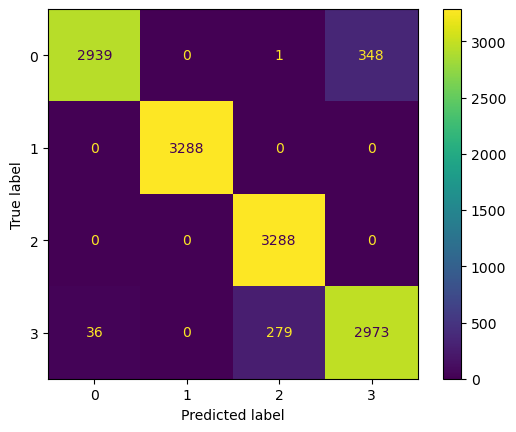

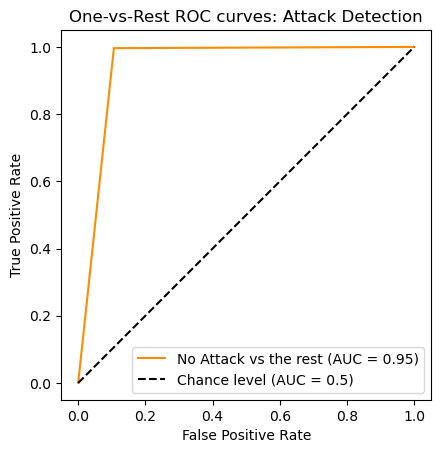

In [17]:
severity = 6
level = 5
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      3288
           1       1.00      1.00      1.00      3288
           2       0.95      1.00      0.97      3288
           3       0.88      0.80      0.84      3288

    accuracy                           0.92     13152
   macro avg       0.92      0.92      0.92     13152
weighted avg       0.92      0.92      0.92     13152

Confusion Matrix:


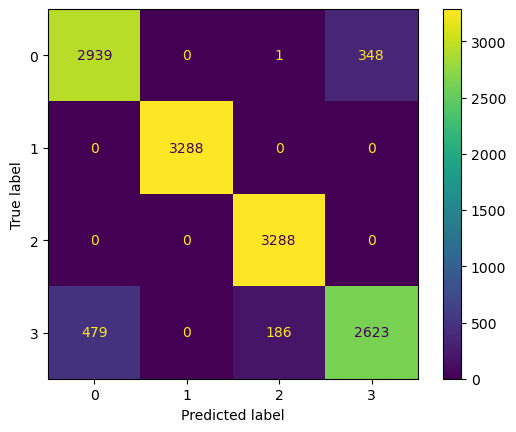

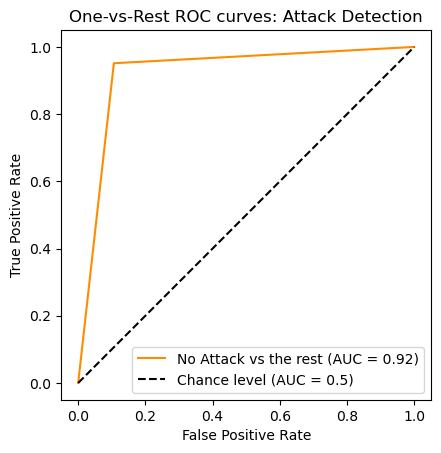

In [18]:
severity = 7
level = 5
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.89      0.77      3288
           1       1.00      1.00      1.00      3288
           2       0.96      1.00      0.98      3288
           3       0.83      0.52      0.64      3288

    accuracy                           0.85     13152
   macro avg       0.87      0.85      0.85     13152
weighted avg       0.87      0.85      0.85     13152

Confusion Matrix:


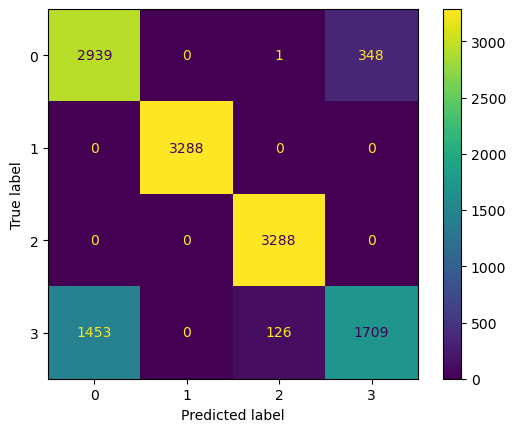

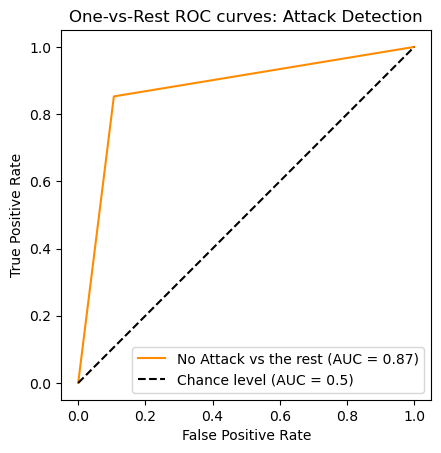

In [19]:
severity = 8
level = 5
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.89      0.64      3288
           1       1.00      0.61      0.76      3288
           2       0.93      0.63      0.75      3288
           3       0.40      0.38      0.39      3288

    accuracy                           0.63     13152
   macro avg       0.71      0.63      0.64     13152
weighted avg       0.71      0.63      0.64     13152

Confusion Matrix:


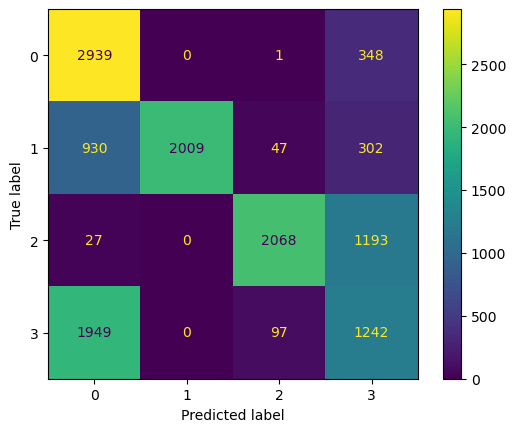

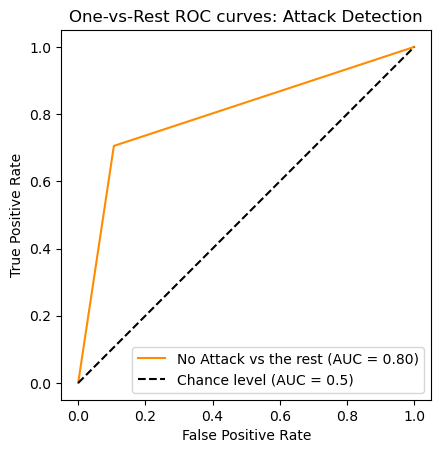

In [20]:
severity = 9
level = 5
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 10%**

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3288
           1       1.00      1.00      1.00      3288
           2       0.84      1.00      0.92      3288
           3       0.85      0.81      0.83      3288

    accuracy                           0.92     13152
   macro avg       0.92      0.92      0.92     13152
weighted avg       0.92      0.92      0.92     13152

Confusion Matrix:


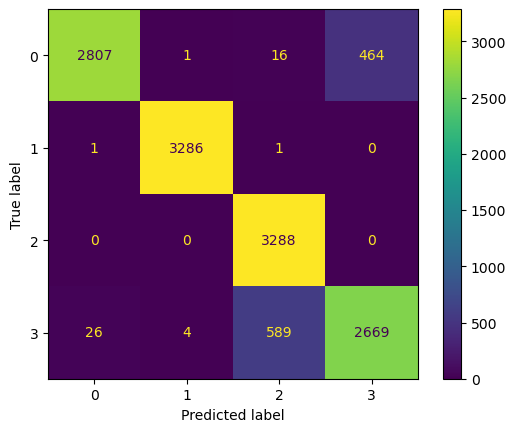

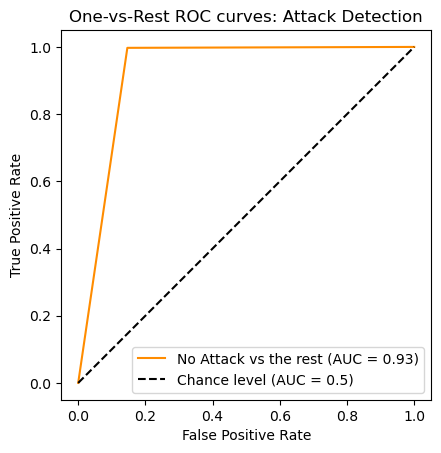

In [21]:
severity = 5
level = 10
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      3288
           1       1.00      1.00      1.00      3288
           2       0.88      1.00      0.94      3288
           3       0.86      0.83      0.84      3288

    accuracy                           0.92     13152
   macro avg       0.92      0.92      0.92     13152
weighted avg       0.92      0.92      0.92     13152

Confusion Matrix:


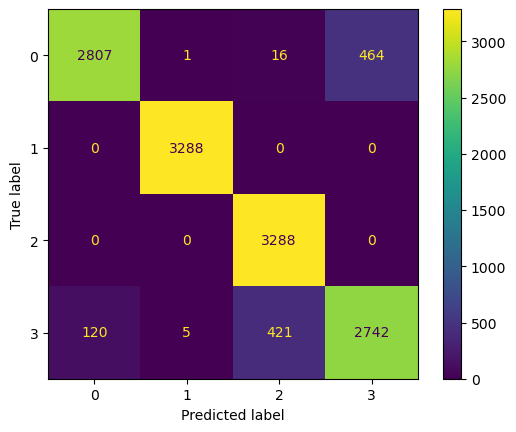

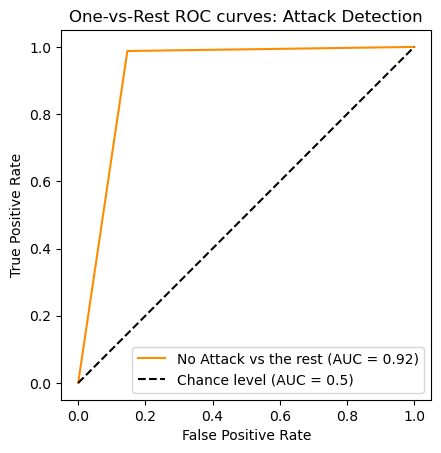

In [22]:
severity = 6
level = 10
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3288
           1       0.99      1.00      1.00      3288
           2       0.91      1.00      0.95      3288
           3       0.84      0.75      0.79      3288

    accuracy                           0.90     13152
   macro avg       0.90      0.90      0.90     13152
weighted avg       0.90      0.90      0.90     13152

Confusion Matrix:


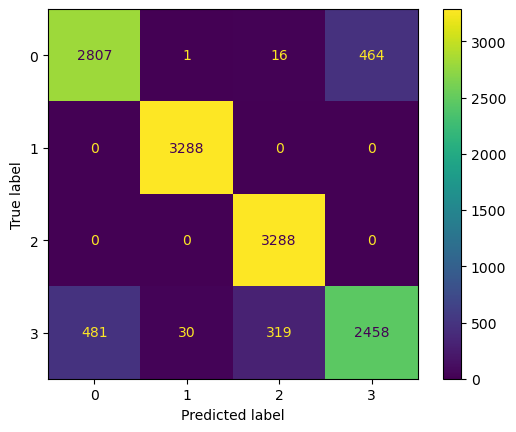

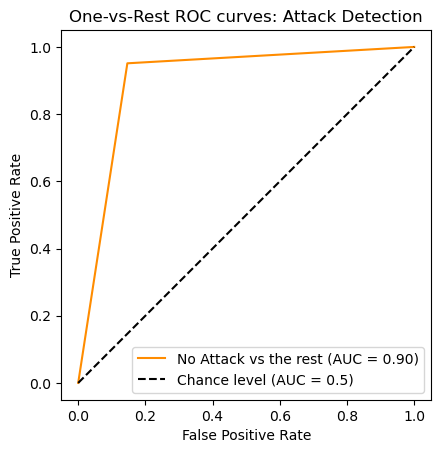

In [23]:
severity = 7
level = 10
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3288
           1       0.97      1.00      0.98      3288
           2       0.93      1.00      0.96      3288
           3       0.81      0.59      0.68      3288

    accuracy                           0.86     13152
   macro avg       0.86      0.86      0.85     13152
weighted avg       0.86      0.86      0.85     13152

Confusion Matrix:


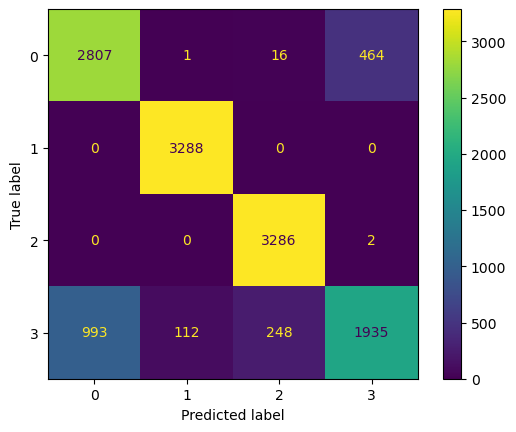

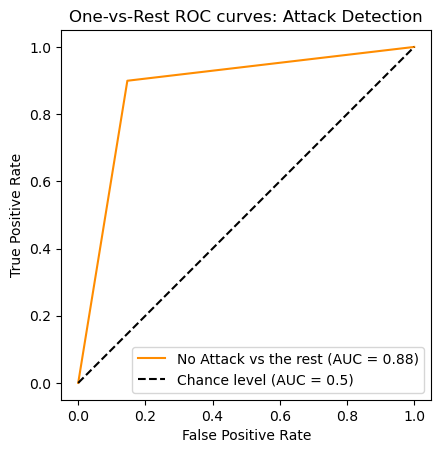

In [24]:
severity = 8
level = 10
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.85      0.73      3288
           1       0.93      0.93      0.93      3288
           2       0.88      0.69      0.77      3288
           3       0.51      0.44      0.47      3288

    accuracy                           0.73     13152
   macro avg       0.74      0.73      0.73     13152
weighted avg       0.74      0.73      0.73     13152

Confusion Matrix:


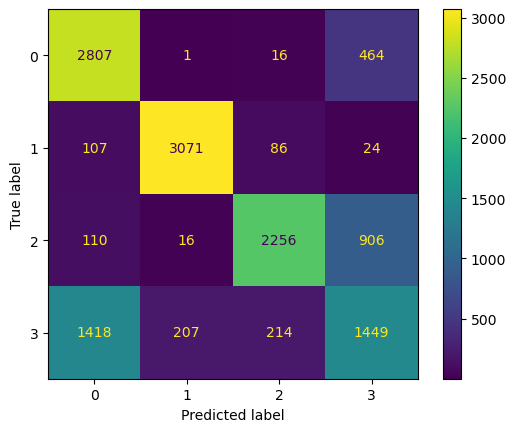

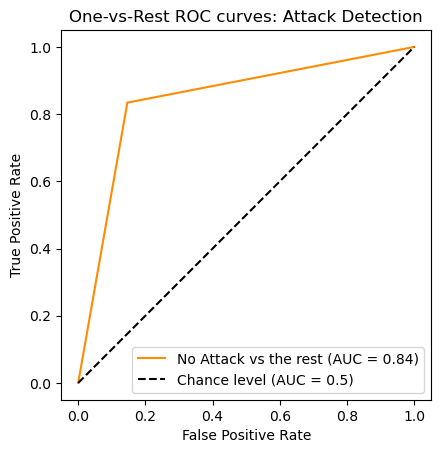

In [25]:
severity = 9
level = 10
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 20%**

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      1.00      1.00      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


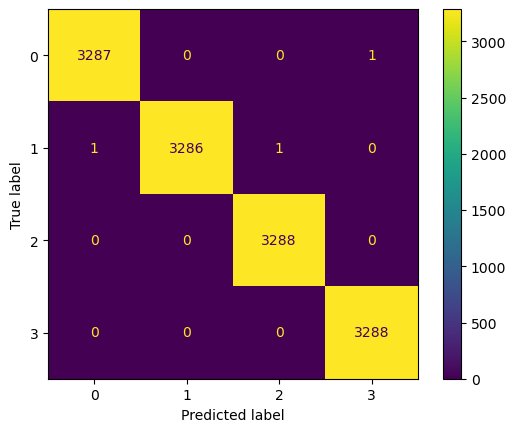

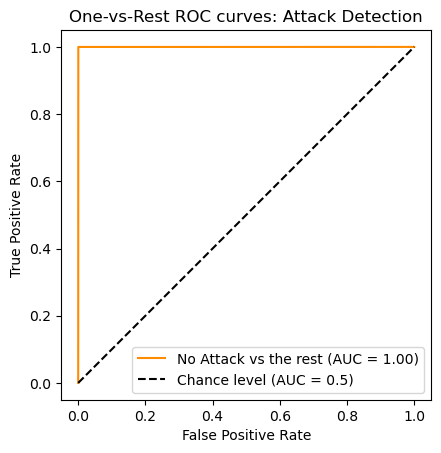

In [26]:
severity = 5
level = 20
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      0.99      0.99      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


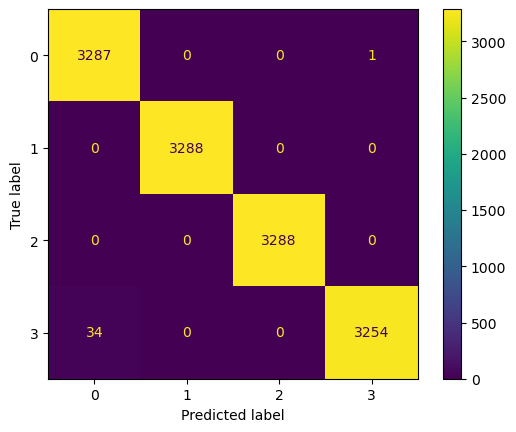

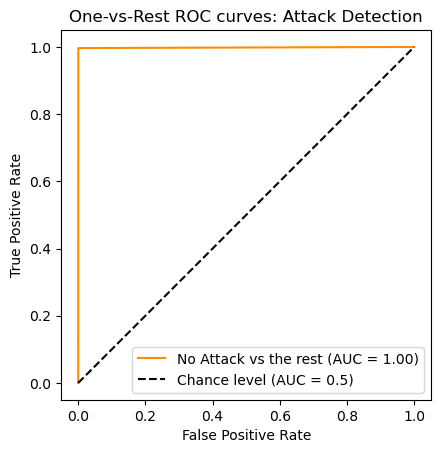

In [27]:
severity = 6
level = 20
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3288
           1       0.99      1.00      0.99      3288
           2       1.00      1.00      1.00      3288
           3       1.00      0.74      0.85      3288

    accuracy                           0.94     13152
   macro avg       0.95      0.94      0.93     13152
weighted avg       0.95      0.94      0.93     13152

Confusion Matrix:


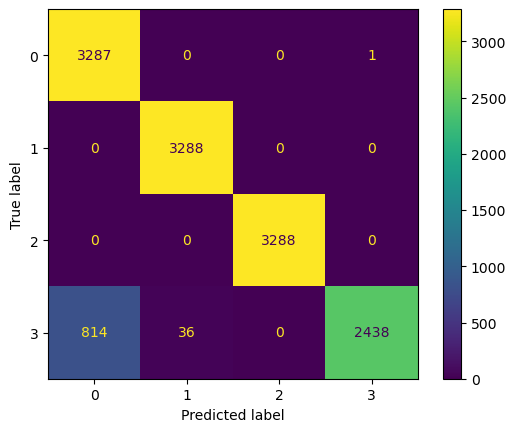

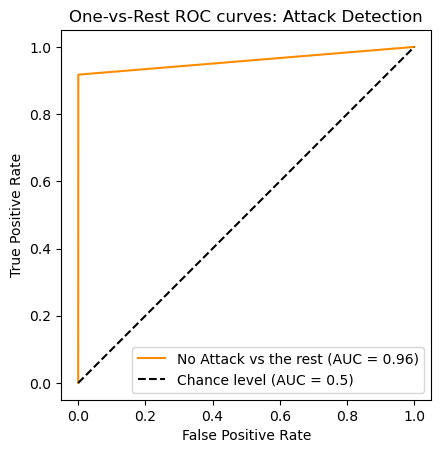

In [28]:
severity = 7
level = 20
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3288
           1       0.97      1.00      0.99      3288
           2       1.00      1.00      1.00      3288
           3       1.00      0.31      0.48      3288

    accuracy                           0.83     13152
   macro avg       0.89      0.83      0.80     13152
weighted avg       0.89      0.83      0.80     13152

Confusion Matrix:


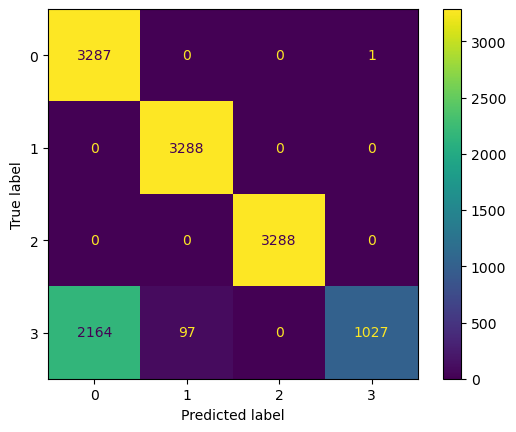

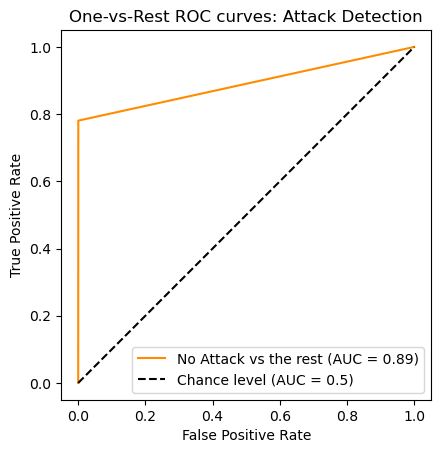

In [29]:
severity = 8
level = 20
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      3288
           1       0.95      0.90      0.92      3288
           2       1.00      0.27      0.43      3288
           3       0.16      0.13      0.14      3288

    accuracy                           0.58     13152
   macro avg       0.66      0.58      0.55     13152
weighted avg       0.66      0.58      0.55     13152

Confusion Matrix:


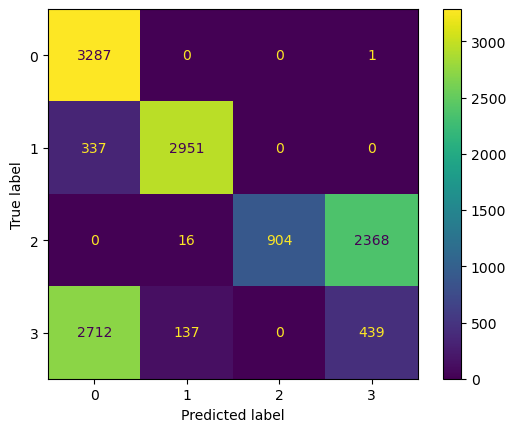

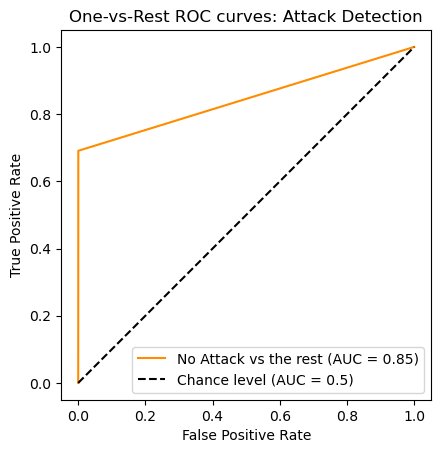

In [30]:
severity = 9
level = 20
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 50%**

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      1.00      1.00      3288

    accuracy                           1.00     13152
   macro avg       1.00      1.00      1.00     13152
weighted avg       1.00      1.00      1.00     13152

Confusion Matrix:


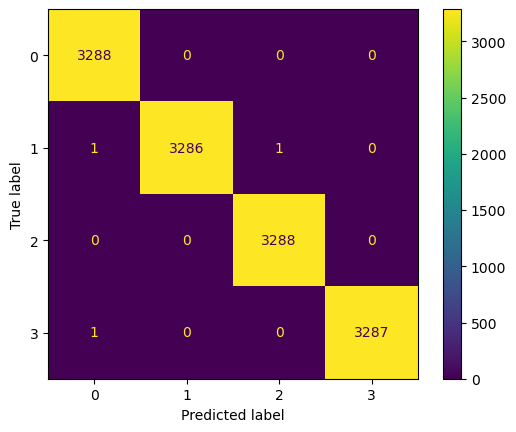

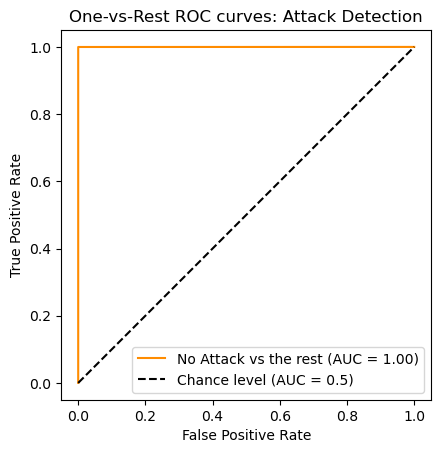

In [31]:
severity = 5
level = 50
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      0.96      0.98      3288

    accuracy                           0.99     13152
   macro avg       0.99      0.99      0.99     13152
weighted avg       0.99      0.99      0.99     13152

Confusion Matrix:


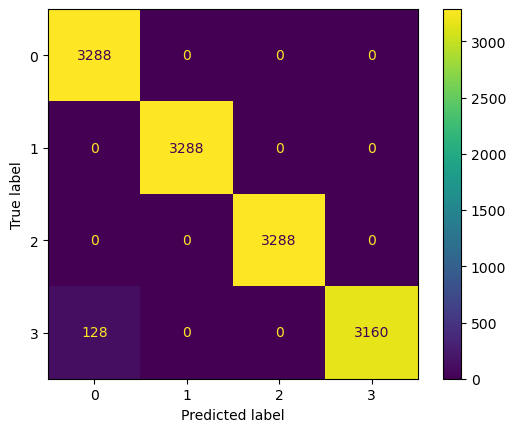

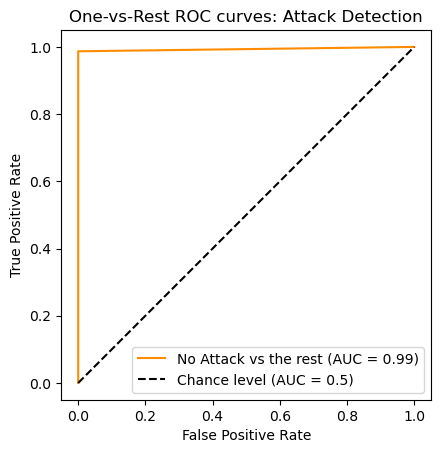

In [32]:
severity = 6
level = 50
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      0.59      0.74      3288

    accuracy                           0.90     13152
   macro avg       0.93      0.90      0.89     13152
weighted avg       0.93      0.90      0.89     13152

Confusion Matrix:


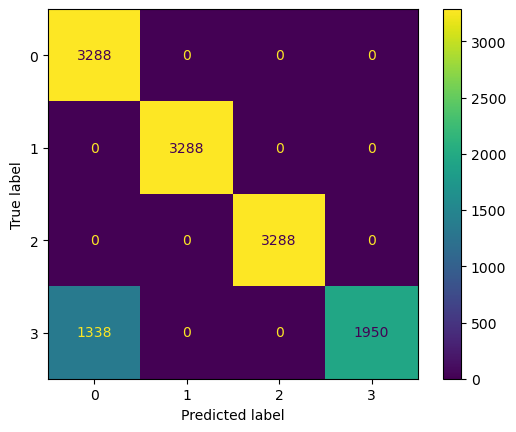

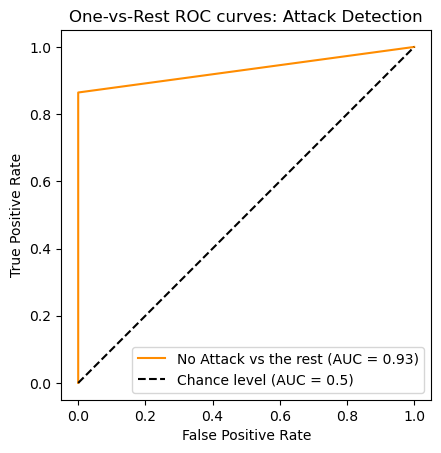

In [33]:
severity = 7
level = 50
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      3288
           1       1.00      1.00      1.00      3288
           2       1.00      1.00      1.00      3288
           3       1.00      0.21      0.35      3288

    accuracy                           0.80     13152
   macro avg       0.89      0.80      0.77     13152
weighted avg       0.89      0.80      0.77     13152

Confusion Matrix:


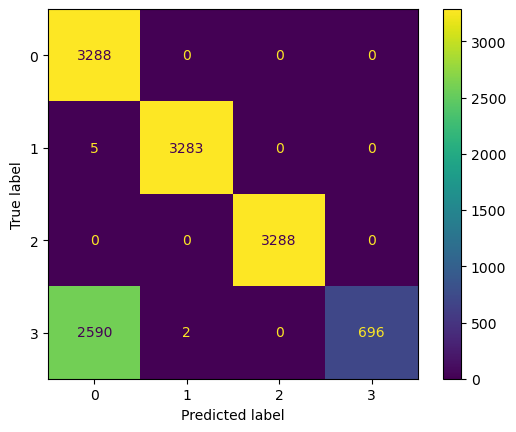

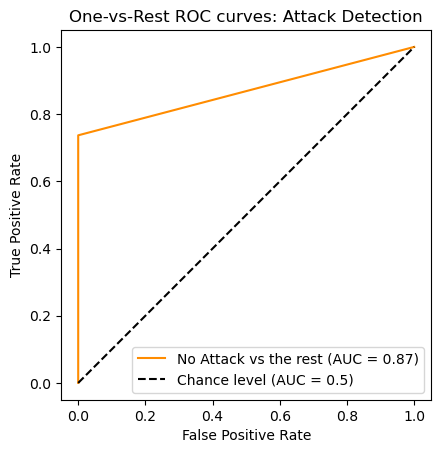

In [34]:
severity = 8
level = 50
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.37      1.00      0.55      3288
           1       0.99      0.24      0.38      3288
           2       1.00      0.13      0.23      3288
           3       0.10      0.09      0.09      3288

    accuracy                           0.36     13152
   macro avg       0.61      0.36      0.31     13152
weighted avg       0.61      0.36      0.31     13152

Confusion Matrix:


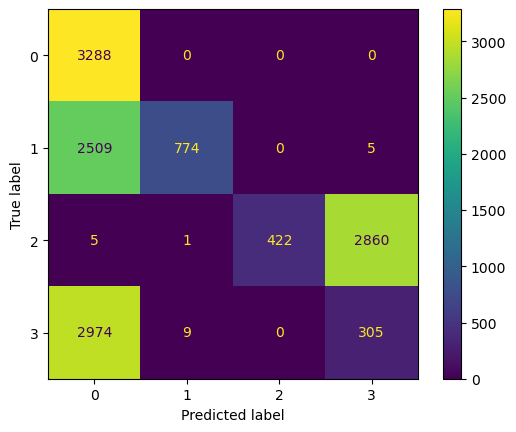

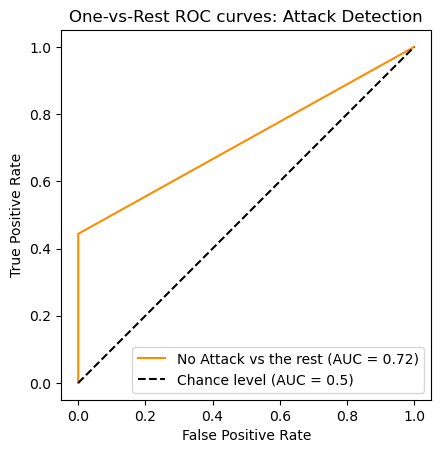

In [35]:
severity = 9
level = 50
pp = torch.argmax(pred[level,severity], dim=1).numpy()
yy = torch.argmax(y, dim=1).numpy()
# report
print("Classification Report:\n")
print(metrics.classification_report(yy, pp, zero_division=0))
# confusion matrix
cm = metrics.confusion_matrix(yy,pp, labels=[0,1,2,3])
print("Confusion Matrix:")
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()
plt.show()
# roc curve 0 vs. rest
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
        }
yy[yy>0] = 1
pp[pp>0] = 1
metrics.RocCurveDisplay.from_predictions(
    yy,
    pp,
    name="No Attack vs the rest",
    color="darkorange"
)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

## **Quantiles**

In [36]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [37]:
severity = 5
mean, low, up = defaultdict(), defaultdict(), defaultdict()
_min = defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            _min_val, _min_id = _pred.min(dim=0)
            _min[k[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 524.03it/s]


In [38]:
_min

defaultdict(None,
            {(0, 0): {3042: 0.8350743055343628},
             (0, 1): {690: 0.0},
             (0, 2): {0: 1.0},
             (0, 3): {3085: 0.009226711466908455},
             (5, 0): {2894: 1.0609926270888081e-08},
             (5, 1): {690: 0.0},
             (5, 2): {0: 1.0},
             (5, 3): {2824: 4.631021965906257e-08},
             (10, 0): {2764: 7.30308608726249e-12},
             (10, 1): {690: 0.0},
             (10, 2): {0: 1.0},
             (10, 3): {1238: 2.1102848635212723e-10},
             (20, 0): {145: 0.2581842243671417},
             (20, 1): {690: 0.0},
             (20, 2): {0: 1.0},
             (20, 3): {167: 0.9867469072341919},
             (50, 0): {3015: 0.6732063889503479},
             (50, 1): {690: 0.0},
             (50, 2): {0: 1.0},
             (50, 3): {933: 0.039787765592336655}})

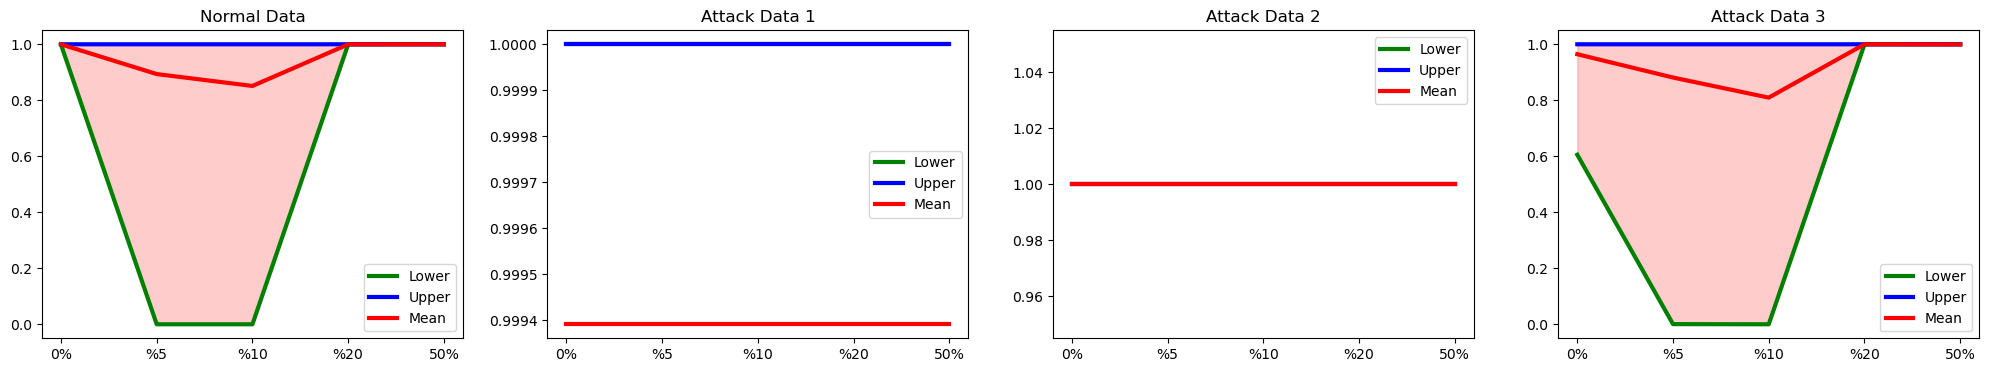

In [39]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 6**

In [40]:
severity = 6
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1379.83it/s]


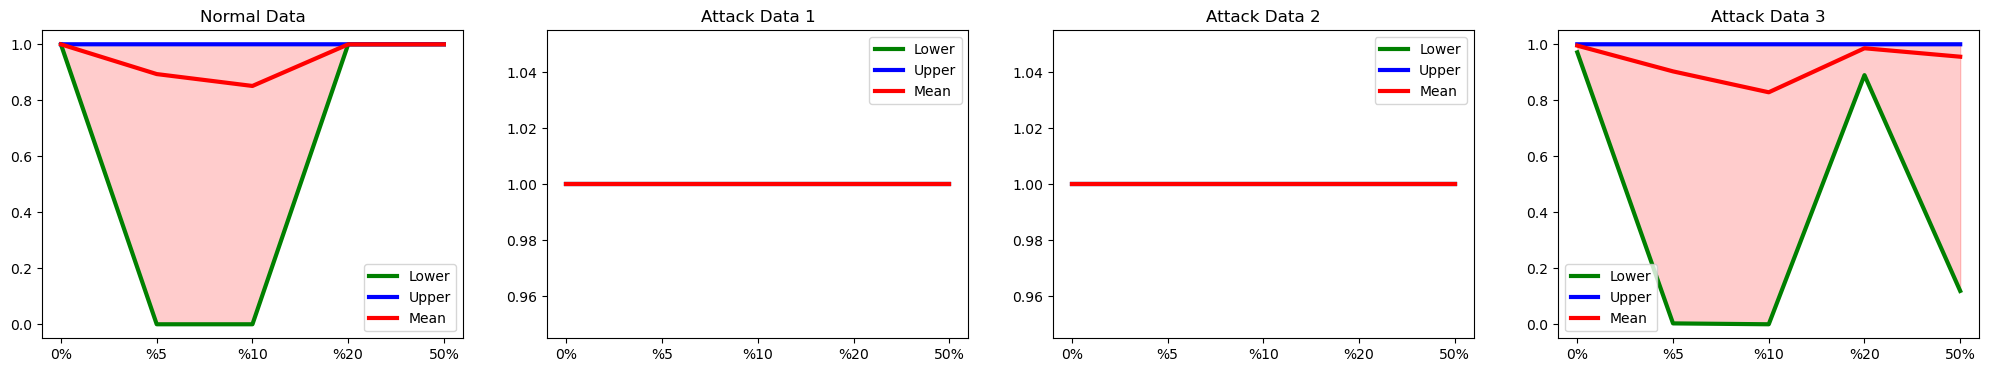

In [41]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 7**

In [42]:
severity = 7
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1348.81it/s]


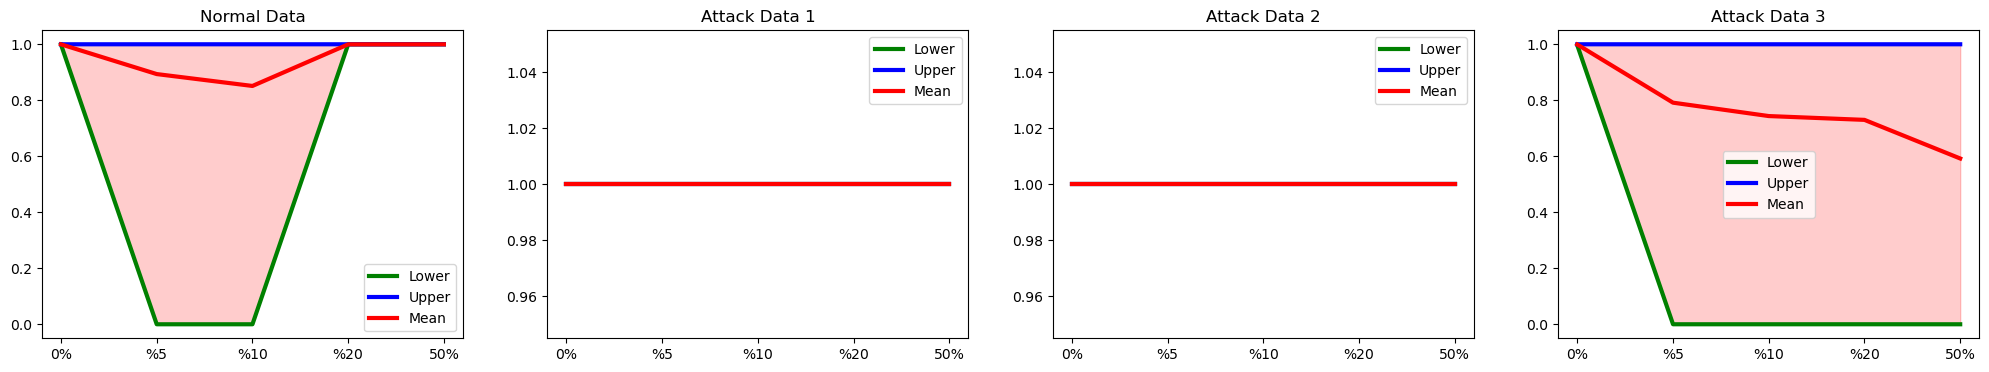

In [43]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 8**

In [44]:
severity = 8
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1329.31it/s]


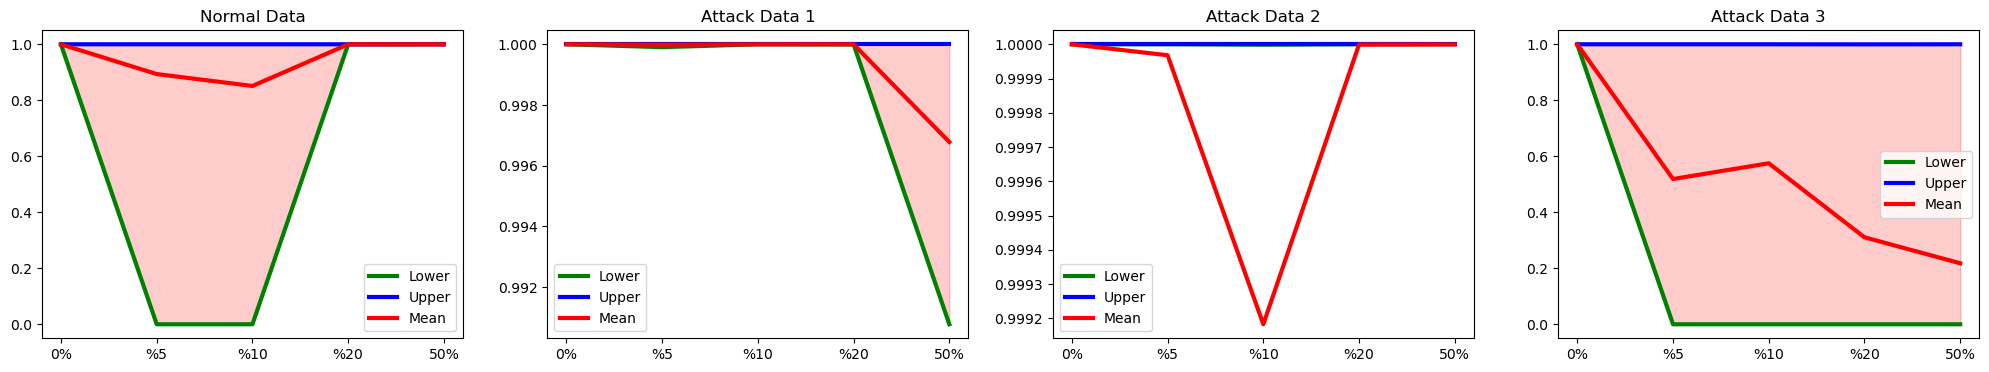

In [45]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()

### **Quantiles: Attack Severity 9**

In [46]:
severity = 9
mean, low, up = defaultdict(), defaultdict(), defaultdict()
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    if k[1] == severity:
        for _type in range(4):
            _pred = v[_type * no_signal:(_type + 1) * no_signal]
            mean[k[0],_type] = _pred.mean(dim=0).numpy()[_type]
            _low, _up = torch.quantile(_pred, q, dim=0).numpy()
            low[k[0], _type], up[k[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 25/25 [00:00<00:00, 1195.07it/s]


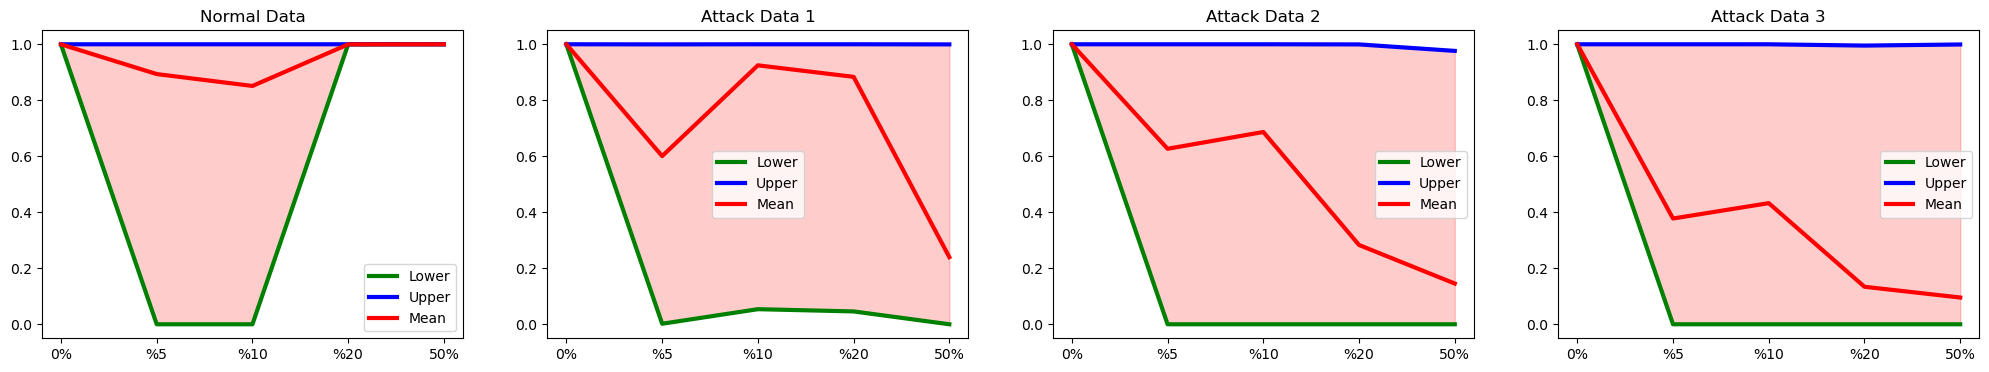

In [47]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(1, 4, figsize=(25, 4))
for _type in range(4):
    _m = [mean[l, _type] for l in noise_levels]
    _l = [low[l, _type] for l in noise_levels]
    _u = [up[l, _type] for l in noise_levels]
    ax[_type].plot(x, _l, label='Lower', lw=3, color='g')
    ax[_type].plot(x, _u, label='Upper', lw=3, color='b')
    ax[_type].plot(x, _m, label='Mean', lw=3, color='r')
    ax[_type].fill_between(x, _l, _u, color='r', alpha=0.2)
    ax[_type].set(xticks=x, xticklabels=x_ax)
    if _type == 0:
        ax[_type].title.set_text('Normal Data')
    else:
        ax[_type].title.set_text(f'Attack Data {_type}')
    ax[_type].legend()
plt.show()